In [7]:
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import torch
import torch.nn as nn

#1) designing the fundamental network

def np_to_torch(x):
    n_samples = len(x)
    return torch.from_numpy(x).to(torch.float).reshape(n_samples, -1)

class Network(nn.Module):
    def __init__(self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None, 
        loss2_weight=0.1,
    ) -> None:
        super().__init__()

        self.epochs = epochs
        self.loss = loss
        self.loss2 = loss2
        self.loss2_weight = loss2_weight
        self.lr = lr
        self.lr = lr
        self.n_units = n_units

        self.layers = nn.Sequential(
            nn.Linear(input_dim, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
            nn.Linear(self.n_units, self.n_units),
            nn.ReLU(),
        )
        self.out = nn.Linear(self.n_units, output_dim)

    def forward(self, x):
        h = self.layers(x)
        out = self.out(h)
        return out
    
    def fit(self, X, y):
        Xtensor = np_to_torch(X)
        ytensor = np_to_torch(y) #.float gives float32

        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        self.train()
        losses = []

        for ep in range(self.epochs):
            optimizer.zero_grad()
            outputs = self.forward(Xtensor)
            loss = self.loss(ytensor, outputs)

            if self.loss2:
                loss += self.loss2_weight * self.loss2(self)

            loss.backward()
            optimizer.step()
            losses.append(loss.item())

            if ep % int(self.epochs/10) == 0:
                print(f"Epoch: {ep}/{self.epochs}, loss: {losses[-1]:.2f}")

        return losses
    
    def predict(self, X):
        self.eval()
        X_tensor = np_to_torch(X)
        out = self.forward(X_tensor)  #added the reshape part last, remove to restore last version
        return out.detach().numpy()


class NetworkInverse(Network):

    def __init__(
        self,
        input_dim,
        output_dim,
        n_units=100,
        epochs=1000,
        loss=nn.MSELoss(),
        lr=0.001,
        loss2=None,
        loss2_weight=0.1,
    ) -> None:
        super().__init__(input_dim, output_dim, n_units, epochs, loss, lr, loss2, loss2_weight)

        self.r = nn.Parameter(data=torch.tensor([0.])) 

(1000,)
(1000,)
(10,)
(10,)


Text(0.5, 0, 'Time (s)')

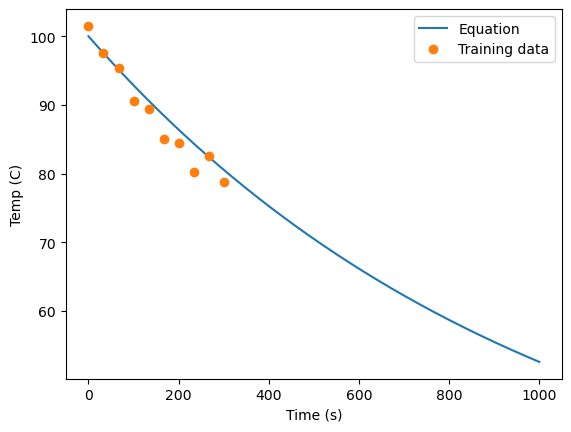

In [9]:
# before we can train our model, we need to generate the data
# to train it on (training data)

# note, for comparison, we will also generate the true data and
# plot it too

Tenv = 25 #temp of environment
T0 = 100 #initial temperature
k = 0.001 #arbitrary start point for cooling const.
time = np.linspace(0,1000,1000)
np.random.seed()

def true_sol(t):
    return Tenv + (T0 - Tenv)*np.exp(-k*t)

temp = true_sol(time)

t = np.linspace(0,300,10) # for taining data, only up to 300 with step 10
T = true_sol(t) + 2*np.random.randn(10)


print(np.shape(time))
print(np.shape(temp))
print(np.shape(t))
print(np.shape(T))


plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.legend(['Equation', 'Training data'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')





In [10]:
from torch.autograd import grad

def physics_loss(model: torch.nn.Module):
    t = torch.linspace(0,1000,steps=1000).view(-1,1).requires_grad_(True).to(torch.float32)
    T = model(t)
    dT = grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]  #we need [0] because the output of grad
                        # is a tuple, 1000 rows, 1 element per row
    pde = k*(Tenv - T) - dT  #predicted pde vals (y_hat)

    return torch.mean(pde**2).to(torch.float32) #note this is the MSE Loss

Epoch: 0/20000, loss: 7440.39
Epoch: 2000/20000, loss: 2800.42
Epoch: 4000/20000, loss: 2406.46
Epoch: 6000/20000, loss: 356.16
Epoch: 8000/20000, loss: 1.49
Epoch: 10000/20000, loss: 1.30
Epoch: 12000/20000, loss: 1.26
Epoch: 14000/20000, loss: 1.19
Epoch: 16000/20000, loss: 1.15
Epoch: 18000/20000, loss: 1.11


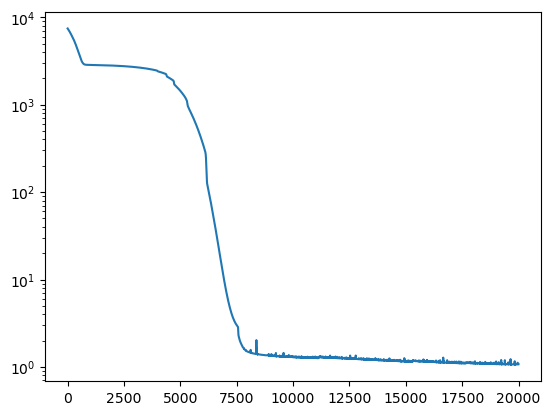

In [11]:
# now to see how the loss changes over time

network = Network(input_dim=1,output_dim=1,loss2=physics_loss,epochs=20000,loss2_weight=1,lr=1e-5)

losses = network.fit(t,T)
plt.plot(losses)
plt.yscale('log')

Text(0.5, 0, 'Time (s)')

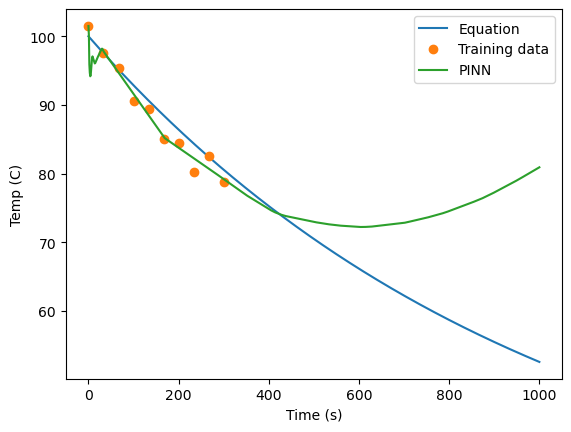

In [12]:
predictions = network.predict(time)

plt.plot(time, temp)
plt.plot(t, T, 'o')
plt.plot(time, predictions)
plt.legend(labels=['Equation', 'Training data', 'PINN'])
plt.ylabel('Temp (C)')
plt.xlabel('Time (s)')

#currently running into the same problem as before
#I think some of the many tensors are different shapes 
#so cannot be multiplied together